In [13]:
# Load all_teams_performance_data.csv into a pandas dataframe
import pandas as pd
df = pd.read_csv('all_teams_performance_data.csv')
# Add new column called year which is the first 4 characters of the event_key column
df['year'] = df['event_key'].str[:4].astype(int)

In [14]:
# Copy the dataframe to a new dataframe'
# The new dataframe contains only in-season data where opr is not none and the week is not none
in_season_df = df[(df['opr'].notnull()) & (df['week'].notnull())]

In [15]:
def get_df(year=None, weeks=None, state_prov=None):
    df_filtered = in_season_df.copy()
    
    if year is not None:
        df_filtered = df_filtered[df_filtered['year'].isin(year)]
    
    if weeks is not None:
        df_filtered = df_filtered[df_filtered['week'].isin(weeks)]
    
    if state_prov is not None:
        df_filtered = df_filtered[df_filtered['state_prov'] == state_prov]
    
    return df_filtered

In [16]:
# Add column called normalized_opr which is the opr divided by the max opr for that year (get_opr_100_mean())
mean_opr_per_year = in_season_df.groupby('year')['opr'].transform(lambda x: x.nlargest(1).mean())
in_season_df.loc[:, 'normalized_opr'] = in_season_df['opr'] / mean_opr_per_year

C:\Users\20213116\AppData\Local\Temp\ipykernel_16304\2874919078.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



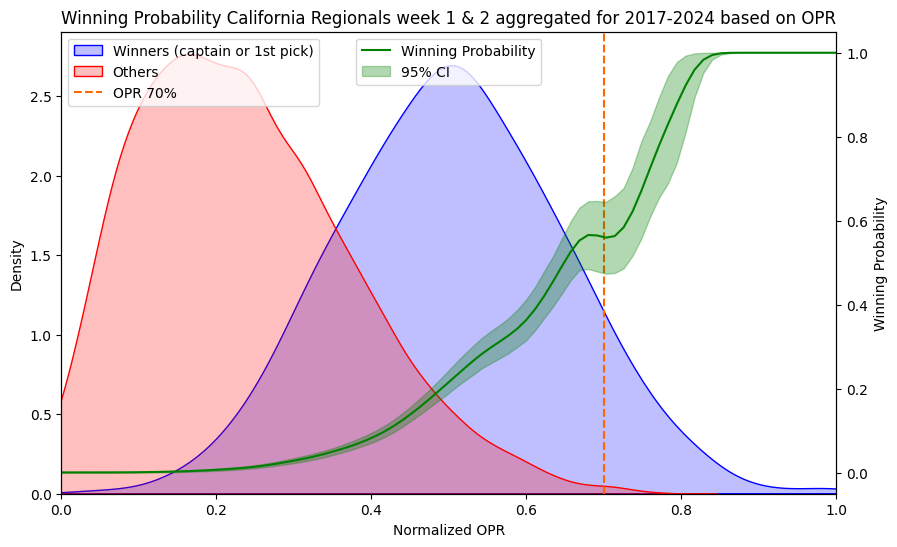

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from sklearn.utils import resample

def plot_opr_distribution_with_bootstrap(df, n_bootstrap=1000):
    if df.empty:
        print('Dataframe is empty')
        return

    years = df['year'].unique()
    opr_70 = 0.7

    # Assuming in_season_2017_df is your DataFrame
    won_pick_teams = df[(df['status'] == 'won') & (df['pick'] <= 1)]
    other_teams = df[~((df['status'] == 'won') & (df['pick'] <= 1))]

    # Define the OPR target
    opr_target = opr_70

    # Define a range of OPR values
    opr_values = np.linspace(df['normalized_opr'].min(), df['normalized_opr'].max(), 100)

    # Initialize arrays to store bootstrap results
    bootstrap_probabilities = np.zeros((n_bootstrap, len(opr_values)))

    # Perform bootstrapping
    for i in range(n_bootstrap):
        # Resample the data with replacement
        df_resampled = resample(df)

        # Split the resampled data into winning and other teams
        won_pick_teams_resampled = df_resampled[(df_resampled['status'] == 'won') & (df_resampled['pick'] <= 1)]
        other_teams_resampled = df_resampled[~((df_resampled['status'] == 'won') & (df_resampled['pick'] <= 1))]

        # Calculate the KDE using scipy.stats.gaussian_kde
        kde_won = gaussian_kde(won_pick_teams_resampled['normalized_opr'])
        kde_other = gaussian_kde(other_teams_resampled['normalized_opr'])

        # Evaluate the KDE at the range of OPR values
        density_won = kde_won(opr_values)
        density_other = kde_other(opr_values)

        # Calculate the proportion of teams in each group
        proportion_won = len(won_pick_teams_resampled) / len(df_resampled)
        proportion_other = len(other_teams_resampled) / len(df_resampled)

        # Adjust the densities by the proportions
        adjusted_density_won = density_won * proportion_won
        adjusted_density_other = density_other * proportion_other

        # Calculate the winning probability for each OPR value
        total_density = adjusted_density_won + adjusted_density_other
        probability_winning = adjusted_density_won / total_density

        # Store the results
        bootstrap_probabilities[i, :] = probability_winning

    # Calculate the mean and confidence intervals
    mean_probability_winning = np.mean(bootstrap_probabilities, axis=0)
    lower_ci = np.percentile(bootstrap_probabilities, 2.5, axis=0)
    upper_ci = np.percentile(bootstrap_probabilities, 97.5, axis=0)

    # Plot the KDE and the winning probability
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot the KDE
    sns.kdeplot(won_pick_teams['normalized_opr'], color='b', label='Winners (captain or 1st pick)', fill=True, ax=ax1)
    sns.kdeplot(other_teams['normalized_opr'], color='r', label='Others', fill=True, ax=ax1)

    # Add vertical line for OPR target
    ax1.axvline(round(opr_target, 2), color='#ff6600', linestyle='--', label='OPR 70%')

    # Add labels and title
    ax1.set_xlabel('Normalized OPR')
    ax1.set_ylabel('Density')
    #ax1.set_title('Distribution of Normalized OPR in {}'.format(years))
    ax1.set_title('Winning Probability California Regionals week 1 & 2 aggregated for 2017-2024 based on OPR')

    # Add a legend
    ax1.legend(loc='upper left')

    # Limit the x-axis to 1.0
    ax1.set_xlim(0, 1.0)

    # Create a second y-axis for the winning probability
    ax2 = ax1.twinx()
    ax2.plot(opr_values, mean_probability_winning, color='g', label='Winning Probability')
    ax2.fill_between(opr_values, lower_ci, upper_ci, color='g', alpha=0.3, label='95% CI')
    ax2.set_ylabel('Winning Probability')

    # Add a legend for the second y-axis
    ax2.legend(loc='upper center')

    # Show the plot
    plt.show()

# Example usage:
plot_opr_distribution_with_bootstrap(get_df(year=[2017,2018,2019,2022,2023,2024], weeks=[0,1]), n_bootstrap=1000)

In [13]:
# print all unique state_prov values
print(in_season_df['state_prov'].unique())

['AB' 'AL' 'AR' 'NSW' 'AZ' 'CA' 'VA' 'CO' 'CT' 'FL' 'GA' 'Guangdong Sheng'
 'HI' 'IA' 'ID' 'IL' 'IN' 'Tel Aviv District' 'Haifa District' 'LA' 'MA'
 'MD' 'ME' 'MI' 'MN' 'MO' 'PA' 'MEX' 'Coah.' 'NC' 'NH' 'NJ' 'NV' 'NY' 'OH'
 'OK' 'ON' 'OR' 'WA' 'QC' 'RI' 'SC' 'TN' 'TX' 'UT' 'WI' 'BC' 'N.L.' 'ND'
 'Shanghai Shi' 'Istanbul' 'KS' 'CDMX' 'İstanbul' 'DC'
 'Jerusalem District' 'Center District' 'NWT' '35' 'DF' 'MS' 'Pue.' '34'
 'SON']


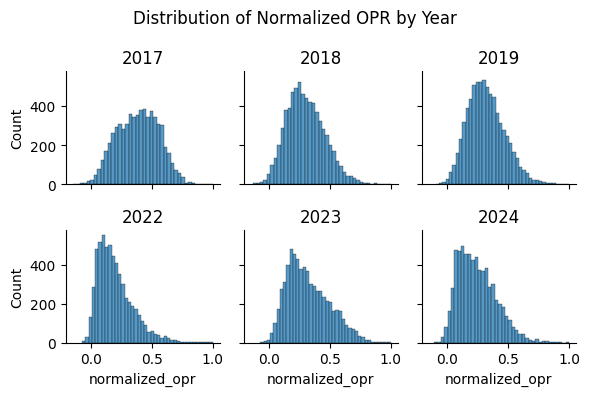

In [30]:
import pandas as pd
import seaborn as sns


# Load the data
df = pd.read_csv('all_teams_performance_data.csv')

# Filter the data
df = df[(df['opr'].notnull()) & (df['week'].notnull())]

df['year'] = df['event_key'].str[:4].astype(int)

# Remove 2020 data
df = df[df['year'] != 2020]

# Add column called normalized_opr which is the opr divided by the max opr for that year
max_opr_per_year = df.groupby('year')['opr'].transform(lambda x: x.nlargest(1).mean())
df.loc[:, 'normalized_opr'] = df['opr'] / max_opr_per_year

# Show a histogram of normalized OPR for each year from 2017 to 2024 (use a facet grid)
df_temp = df.copy()

# Create a FacetGrid
g = sns.FacetGrid(df_temp, col='year', col_wrap=3, height=2)

# Map a histogram to each year
g.map(sns.histplot, 'normalized_opr', bins=40, kde=False)

# Add a title to the overall plot
g.fig.suptitle('Distribution of Normalized OPR by Year')
g.fig.subplots_adjust(top=0.85)

# Add titles to each plot
for ax, title in zip(g.axes.flat, ['2017', '2018', '2019', '2022', '2023', '2024']):
    ax.set_title(title)

# add some space between the plots vertically
plt.tight_layout()

# Show the plot
plt.show()

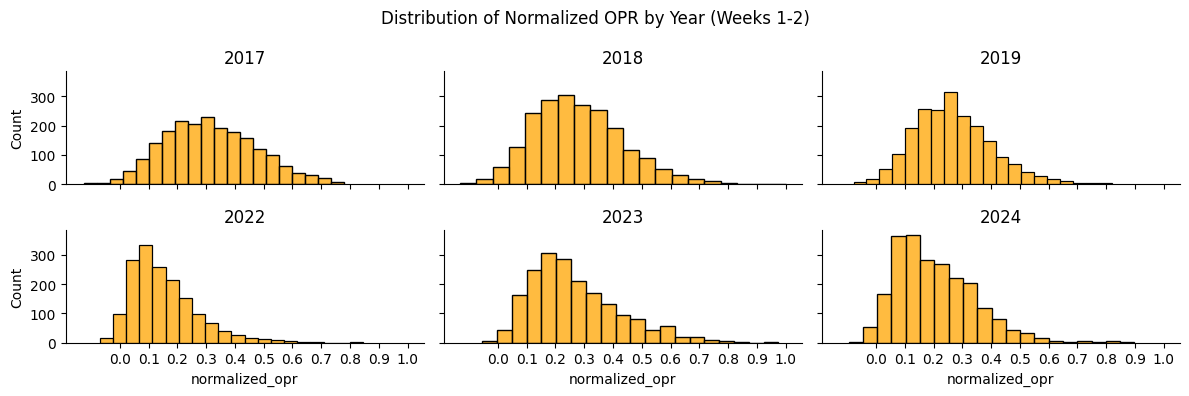

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Make same plot but only for winners (first pick or captain)
# Show a histogram of normalized OPR for each year from 2017 to 2024 (use a facet grid)
df_temp = df.copy()
""" df_temp = df_temp[df_temp['status'] == 'won']
df_temp = df_temp[df_temp['pick'] <= 1] """
df_temp = df_temp[df_temp['week'] <= 1]

# Create a FacetGrid with increased width
g = sns.FacetGrid(df_temp, col='year', col_wrap=3, height=2, aspect=2)

# Map a histogram to each year
g.map(sns.histplot, 'normalized_opr', bins=20, kde=False, color='orange')

# Add a title to the overall plot
g.fig.suptitle('Distribution of Normalized OPR by Year (Weeks 1-2)')
g.fig.subplots_adjust(top=0.85)

# Add titles to each plot
for ax, title in zip(g.axes.flat, ['2017', '2018', '2019', '2022', '2023', '2024']):
    ax.set_title(title)
    ax.set_xticks(np.arange(0, 1.1, 0.1))

# add some space between the plots vertically
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
# I want to write a script that plots the map of the US with the states colored based on an arbitrary value

# make Choropleth map
import plotly.express as px

df_new = df.copy()
# Also only get week 1 or 2 data
# df_new = df_new[df_new['week'].isin([0, 1])]

# Filter the data on normalized OPR above or equal to 70%
df_new = df_new[df_new['normalized_opr'] >= 0.7]

# Calculate the average amount of teams with a normalized OPR above 70% per event per state (aggregate the events per state)
state_stats = df_new.groupby(['state_prov', 'event_key']).size().reset_index(name='count')
state_stats = state_stats.groupby('state_prov')['count'].mean().reset_index()


# Create a Choropleth map
fig = px.choropleth(state_stats, 
                    locations='state_prov',
                    locationmode='USA-states',
                    color='count',
                    scope='usa',
                    color_continuous_scale='Oranges',
                    title='70% OPR teams per state',)
fig.show()

# Make a list of teams that reached the 70% OPR threshold. put it in a table with the team number, event key, and normalized OPR
teams = df_new[['team_key', 'event_key', 'normalized_opr', 'opr', 'state_prov', 'year', 'week']]
teams = teams.sort_values('year', ascending=True)
teams = teams.reset_index(drop=True)

# Save the table to a csv file
teams.to_csv('teams_above_70_opr.csv', index=False)


C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:718: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.

C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\20213116\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\20213116\Ap

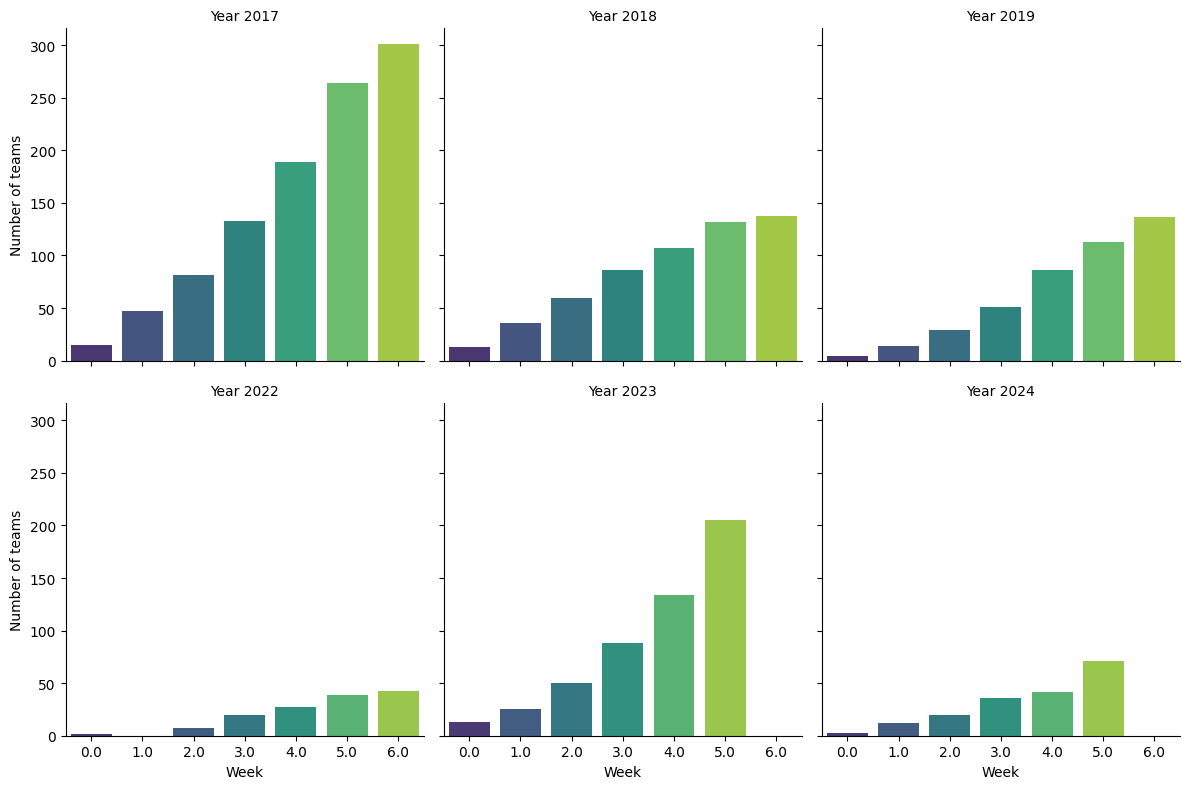

    year  week  count
0   2017   0.0     15
1   2017   1.0     47
2   2017   2.0     81
3   2017   3.0    133
4   2017   4.0    189
5   2017   5.0    264
6   2017   6.0    301
7   2018   0.0     13
8   2018   1.0     36
9   2018   2.0     60
10  2018   3.0     86
11  2018   4.0    107
12  2018   5.0    132
13  2018   6.0    138
14  2019   0.0      4
15  2019   1.0     14
16  2019   2.0     29
17  2019   3.0     51
18  2019   4.0     86
19  2019   5.0    113
20  2019   6.0    137
21  2022   0.0      2
22  2022   2.0      7
23  2022   3.0     20
24  2022   4.0     27
25  2022   5.0     39
26  2022   6.0     43
27  2023   0.0     13
28  2023   1.0     25
29  2023   2.0     50
30  2023   3.0     88
31  2023   4.0    134
32  2023   5.0    205
33  2024   0.0      3
34  2024   1.0     12
35  2024   2.0     20
36  2024   3.0     36
37  2024   4.0     42
38  2024   5.0     71


In [13]:
# make a grid of bar plots showing the amount of teams with normalized OPR above 70% for each week per year
# Make sure that each team_key is only counted once per year and that the bar plot is cumulative
# So that if a team competes in week 1 and week 2, it is only counted once in week 1 and not in week 2 but the count for week 2 is the sum of week 1 and week 2
import matplotlib.pyplot as plt
import seaborn as sns

# use df_new
df_new = df.copy()

# Filter the data on normalized OPR above or equal to 70%
df_new = df_new[df_new['normalized_opr'] >= 0.7]

# Calculate the amount of teams with a normalized OPR above 70% per week per year
teams_per_week = df_new.groupby(['year', 'week', 'team_key']).size().reset_index(name='count')
teams_per_week = teams_per_week.groupby(['year', 'week']).size().groupby(level=0).cumsum().reset_index(name='count')

# Create a grid of bar plots
g = sns.FacetGrid(teams_per_week, col='year', col_wrap=3, height=4)
g.map(sns.barplot, 'week', 'count', palette='viridis')
g.set_axis_labels('Week', 'Number of teams')
g.set_titles('Year {col_name}')
g.tight_layout()
plt.show()

# Print all team_keys with their week and year that were used in the bar plots (to check if the bar plots are correct)
print(teams_per_week)